# Imports

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud , ImageColorGenerator
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from collections import Counter
import plotly.express as px
import pandas as pd
from PIL import Image

# !pip install scikit-learn==0.23
# !pip install pyLDAvis==2.1.2
# !pip install pandas==1.2.5

In [3]:
import os
os.chdir(os.getcwd() + "\downloads")

# CLEANING DATA

In [4]:
data = pd.read_excel("british_airways.xlsx")

In [5]:
data.drop("wifi_connectivity" , axis = 1 , inplace = True)

In [6]:
data.drop("Unnamed: 0" , axis = 1 , inplace = True)

In [7]:
data.head()

,name,date,country,review_title,verification,review,type_of_traveller,seat_type,route,date_flown,seat_comfort,cabin_staff_service,food_beverages,inflight_entertainment,ground_service,value_for_money,recommended
0,\nN Mayle,19th May 2023,United States,"""BA is on the skids downhill""",✅ Trip Verified,Words fail to describe this last awful flight...,Solo Leisure,Business Class,London to San Francisco,September 2022,3.0,1.0,1.0,4.0,2.0,2.0,no
1,\nE Heale,17th May 2023,United States,"""Absolutely terrible experience""",✅ Trip Verified,Absolutely terrible experience. The app would...,Solo Leisure,Economy Class,London to Dallas,April 2023,1.0,1.0,3.0,3.0,1.0,1.0,no
2,\nH Mike,17th May 2023,United Kingdom,"""poor service and unhappy customers""",✅ Trip Verified,BA overbook every flight to maximise their inc...,Business,Economy Class,London to Madrid,May 2023,4.0,3.0,1.0,NaN,1.0,1.0,no
3,\nRichard Cruise,17th May 2023,United Kingdom,"""just won't use them again""",✅ Trip Verified,"_x000D_\nThe flights were all on time, except...",Solo Leisure,Economy Class,London to Belfast,May 2023,1.0,3.0,3.0,1.0,1.0,1.0,no
4,\nKathi Blanning,14th May 2023,United States,"""Another bad show""",Not Verified,Only the second time flying BA as first time w...,Couple Leisure,Business Class,Los Angeles to London,May 2023,5.0,5.0,4.0,5.0,1.0,1.0,no


In [8]:
review_data = data[data.review.notna()]
review_data.shape , review_data.isna().sum()

((2020, 17),
 name                        0
 date                        0
 country                     0
 review_title                0
 verification                0
 review                      0
 type_of_traveller           2
 seat_type                   0
 route                       3
 date_flown                  0
 seat_comfort               94
 cabin_staff_service       104
 food_beverages            312
 inflight_entertainment    811
 ground_service             59
 value_for_money             0
 recommended                 0
 dtype: int64)

In [9]:
#Since I want to gain insights into what the customers want to say regarding the services provided by the british airways
#I selected only those rows where customer review is not null only.

In [10]:
review_data.drop("inflight_entertainment" , axis = 1 , inplace = True)
review_data.drop("name" , axis = 1 , inplace = True)
review_data.drop("date" , axis = 1 , inplace = True)


In [11]:
columns = ["type_of_traveller" , "route" , "seat_comfort" , "cabin_staff_service" , "food_beverages" , "ground_service"]
for i in columns:
    review_data[i].fillna(review_data[i].mode().iloc[0] , inplace = True)

In [12]:
review_data.shape , review_data.isna().sum()

((2020, 14),
 country                0
 review_title           0
 verification           0
 review                 0
 type_of_traveller      0
 seat_type              0
 route                  0
 date_flown             0
 seat_comfort           0
 cabin_staff_service    0
 food_beverages         0
 ground_service         0
 value_for_money        0
 recommended            0
 dtype: int64)

In [13]:
review_data.recommended.value_counts()

no     1359
yes     661
Name: recommended, dtype: int64

In [14]:
#Selecting all the rows where recommendation is no to get insights into what are the
#reasons the customer donot want to recommend british airways to someone.
no_data = review_data[review_data.recommended == "no"] 

# PREPROCESSING TEXT FOR CUSTOMER REVIEW FEATURE

In [15]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    clean_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Filter tokens
    clean_text = " ".join(clean_tokens)  # Join tokens back into a string
    return clean_text

no_data["review_clean"] = no_data["review"].apply(lambda x: preprocess_text(x))


[nltk_data] Downloading package stopwords to C:\Users\sejal
[nltk_data]     Jadev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
no_data["review_clean"]

0       words fail describe last awful flight baby acr...
1       absolutely terrible experience app would let c...
2       ba overbook every flight maximise income regar...
3       flights time except belfast london never staff...
4       second time flying ba first time positive coul...
                              ...                        
2174    british airways used better spent afternoon bu...
2179    flight copenhagen london heathrow british airw...
2192    istanbul london heathrow british airways main ...
2194    flown british airways times usually business c...
2197    gatwick amsterdam business class truly uncomfo...
Name: review_clean, Length: 1359, dtype: object

# SENTIMENT ANALYSIS OF CUSTOMER REVIEW FEATURE

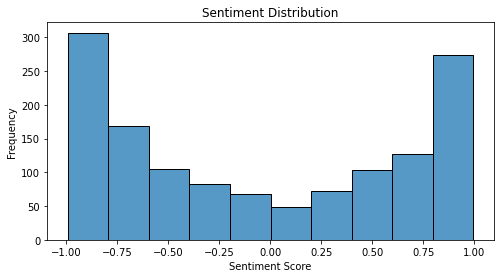

In [74]:
# The compound score represents the overall sentiment of the text, ranging from -1 (extremely negative) to +1 (extremely positive).
sia = SentimentIntensityAnalyzer()
no_data['review_sentiment_score'] = no_data['review_clean'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Visualization - Sentiment distribution
plt.figure(figsize=(8, 4))
sns.histplot(data=no_data, x='review_sentiment_score', bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

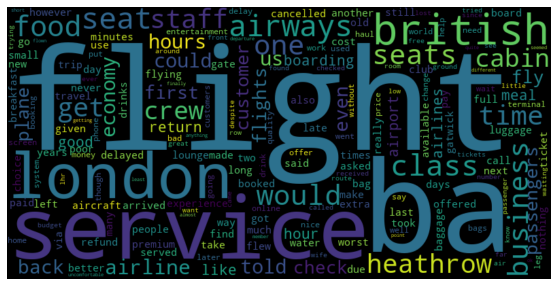

In [18]:
# WORD FREQUENCY

all_text = ' '.join(no_data['review_clean'])
word_freq = Counter(all_text.split())

# WORD CLOUD

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

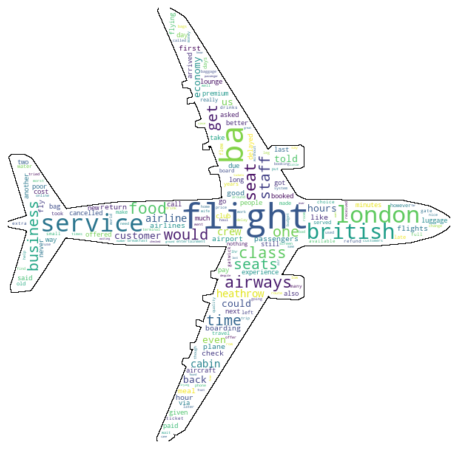

In [68]:
all_text = ' '.join(no_data['review_clean'])
word_freq = Counter(all_text.split())
plane = np.array(Image.open("png.png"))
wordcloud_general = WordCloud(width=800, height=600, background_color='white',
                              contour_width=1, contour_color='black',
                              mask=plane).generate_from_frequencies(word_freq)
# image_colors = ImageColorGenerator(plane)
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
plt.imshow(wordcloud_general, interpolation='bilinear')
plt.axis('off')
plt.show()
wordcloud_general.to_file('wordcloud_plane.pdf')


# LATENT DIRICHLET ALLOCATION

In [20]:
review_vectorizer = TfidfVectorizer()

In [21]:
review_arr = review_vectorizer.fit_transform(no_data['review_clean'])

In [65]:
review_vectorizer_features = review_vectorizer.get_feature_names()


In [23]:
review_lda_model = LatentDirichletAllocation(n_components=4 , max_iter= 50 ,  random_state=42)

review_topic_weights = review_lda_model.fit_transform(review_arr)

review_topic_words = review_lda_model.components_


In [24]:
n_top_words = 20

l = []
for idx , topic_dist in enumerate(review_lda_model.components_):
    sorted_topic_dist = np.argsort(topic_dist)
    top_words_indices = np.array(review_vectorizer_features)[sorted_topic_dist]
    top_words = top_words_indices[:-n_top_words:-1]
    l.append(top_words)

    print("topic" , str(idx + 1) , top_words)
    

topic 1 ['flight' 'ba' 'service' 'class' 'london' 'seat' 'airways' 'british'
 'food' 'business' 'seats' 'staff' 'one' 'heathrow' 'time' 'airline'
 'crew' 'cabin' 'would']
topic 2 ['strolled' 'accuse' 'stealing' 'careless' 'stammers' 'qas' 'kingston'
 'testament' 'foudd' 'dirham' 'unquestionably' 'multitude' 'catastrophe'
 'dilemma' 'rearmost' 'outer' 'withholding' 'bane' 'roof']
topic 3 ['strolled' 'accuse' 'stealing' 'careless' 'stammers' 'qas' 'kingston'
 'testament' 'foudd' 'dirham' 'unquestionably' 'multitude' 'catastrophe'
 'dilemma' 'outer' 'rearmost' 'bane' 'withholding' 'roof']
topic 4 ['std' 'durban' 'towed' 'atd' 'hanger' 'kulula' 'shall' 'comair'
 'includes' 'africa' 'frame' 'friday' 'approached' 'announcements'
 'johannesburg' 'south' 'shocking' 'filthy' 'simply']


In [25]:
review_topic_labels = {
0: "Topic 1",
1: "Topic 2",
2: "Topic 3",
3: "Topic 4"}

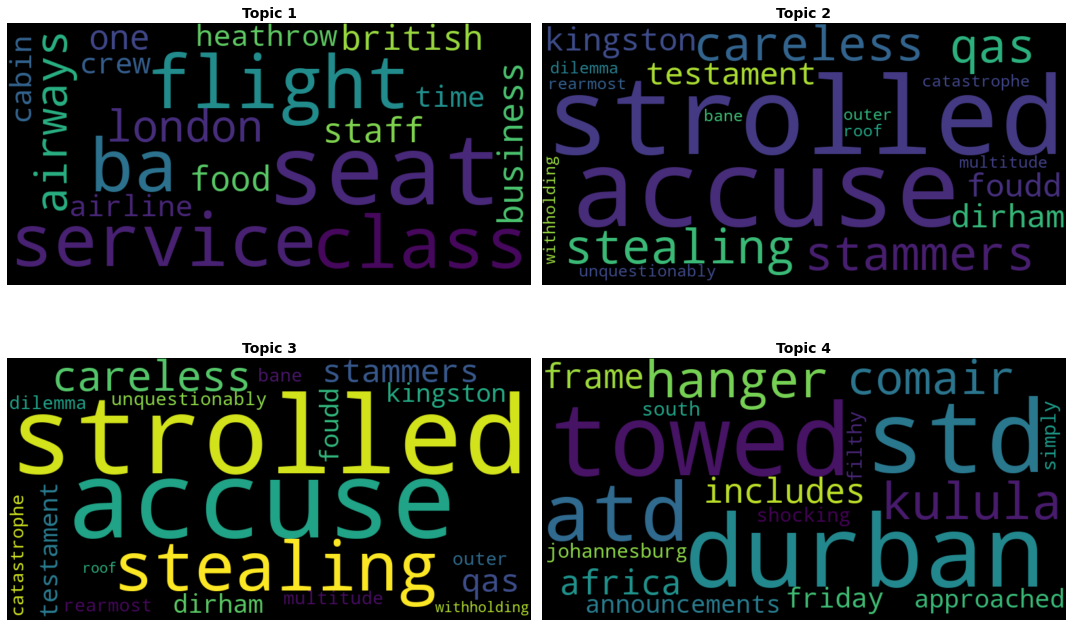

In [26]:
# Visualization - Word clouds for each topic
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(2 ,2, figsize=(15, 10))
axs = axs.flatten()

for idx, topic_words in enumerate(l):
    wordcloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(topic_words))
    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].set_title(review_topic_labels[idx], fontsize=14, fontweight='bold', color='black')
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


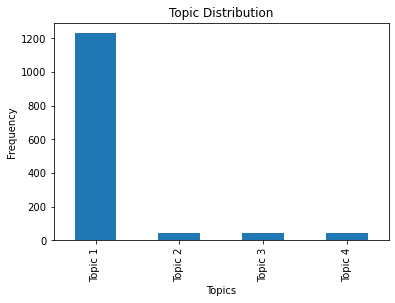

In [27]:
topic_distribution = pd.DataFrame(review_topic_weights)

topic_distribution.columns = [review_topic_labels[i] for i in range(topic_distribution.shape[1])]
topic_distribution.sum().plot(kind='bar')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Topic Distribution')
plt.show()

In [41]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.sklearn
warnings.filterwarnings("ignore", category=DeprecationWarning) 


review_lda_model.fit(review_arr)

# Prepare and display the visualization
prepared_data = pyLDAvis.sklearn.prepare(review_lda_model, review_arr, review_vectorizer)
pyLDAvis.display(prepared_data)


The above one circle majorly suggests us that the customers are highly disappointed:
A - Customer Support/ Customer Service / Ground Staff Service of the company/ Cabin Crew service 
B - Uncomfortable Seats


# REVIEW TITLE FEATURE

Now we will check for review title 

In [44]:

review_title_data =data[data.review_title.notna()]
review_title_data.shape , review_title_data.isna().sum()

((3548, 17),
 name                         0
 date                         0
 country                      0
 review_title                 0
 verification                 0
 review                    1528
 type_of_traveller          770
 seat_type                    2
 route                      775
 date_flown                 778
 seat_comfort               104
 cabin_staff_service        114
 food_beverages             349
 inflight_entertainment    1073
 ground_service             840
 value_for_money              1
 recommended                  0
 dtype: int64)

In [45]:
#Selecting all the rows where recommendation is no to get insights into what are the
#reasons the customer donot want to recommend british airways to someone.
no_title_data = review_title_data[review_title_data.recommended == "no"]
no_title_data.isna().sum()


name                        0
date                        0
country                     0
review_title                0
verification                0
review                    721
type_of_traveller         326
seat_type                   2
route                     329
date_flown                328
seat_comfort              101
cabin_staff_service       111
food_beverages            306
inflight_entertainment    693
ground_service            385
value_for_money             0
recommended                 0
dtype: int64

# PREPROCESSING OF REVIEW TITLE FEATURE

In [46]:
nltk.download('punkt')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    clean_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Filter tokens
    clean_text = " ".join(clean_tokens)  # Join tokens back into a string
    return clean_text

no_title_data["review_title_clean"] = no_title_data["review_title"].apply(lambda x: preprocess_text(x))

[nltk_data] Downloading package punkt to C:\Users\sejal
[nltk_data]     Jadev\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\sejal
[nltk_data]     Jadev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# SENTIMENT ANALYSIS OF REVIEW TITLE 

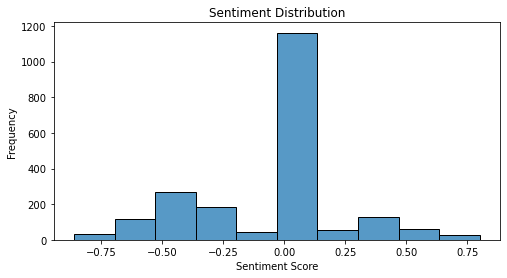

In [73]:
# The compound score represents the overall sentiment of the text, ranging from -1 (extremely negative) to +1 (extremely positive).
sia = SentimentIntensityAnalyzer()
no_title_data['review_title_sentiment_score'] = no_title_data['review_title_clean'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Visualization - Sentiment distribution
plt.figure(figsize=(8, 4))
sns.histplot(data=no_title_data, x='review_title_sentiment_score', bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()

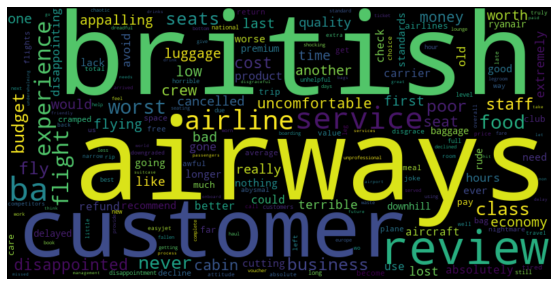

In [48]:
# WORD FREQUENCY

all_text = ' '.join(no_title_data['review_title_clean'])
word_freq = Counter(all_text.split())

# WORD CLOUD

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# REVIEW TITLE LDA

In [49]:
tf_idf_vectorizer = TfidfVectorizer()

tf_idf_arr = tf_idf_vectorizer.fit_transform(no_title_data['review_title_clean'])

tf_idf_features = tf_idf_vectorizer.get_feature_names()

lda_model = LatentDirichletAllocation(n_components=4 , max_iter= 20 ,  random_state=123)

topic_weights = lda_model.fit_transform(tf_idf_arr)

topic_words = lda_model.components_

n_top_words = 10

l = []
for idx , topic_dist in enumerate(lda_model.components_):
    sorted_topic_dist = np.argsort(topic_dist)
    top_words_indices = np.array(tf_idf_features)[sorted_topic_dist]
    top_words = top_words_indices[:-n_top_words:-1]
    l.append(top_words)

    print("topic" , str(idx + 1) , top_words)

topic 1 ['service' 'ba' 'experience' 'airline' 'bad' 'appalling' 'disappointing'
 'terrible' 'another']
topic 2 ['airline' 'never' 'ba' 'fly' 'poor' 'service' 'flying' 'budget' 'flight']
topic 3 ['disappointed' 'food' 'uncomfortable' 'seats' 'worth' 'time' 'cost'
 'aircraft' 'old']
topic 4 ['customer' 'british' 'airways' 'review' 'worst' 'class' 'business'
 'money' 'avoid']


In [50]:
topic_labels = {
0: "Topic 1",
1: "Topic 2",
2: "Topic 3",
3: "Topic 4"}

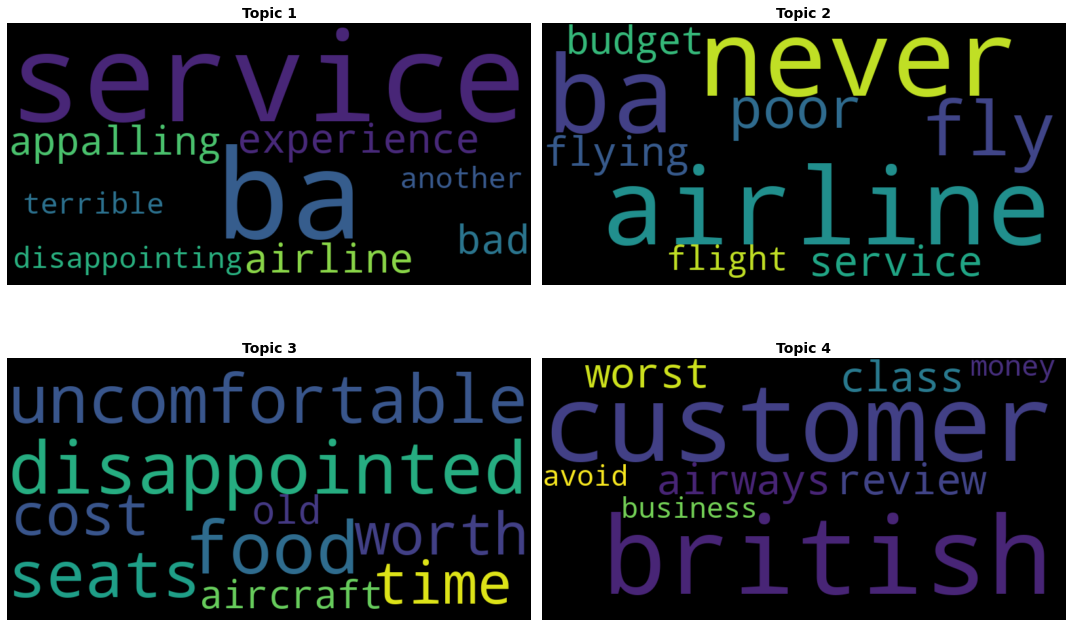

In [51]:
# Visualization - Word clouds for each topic
import matplotlib.pyplot as plt
from wordcloud import WordCloud

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
axs = axs.flatten()

for idx, topic_words in enumerate(l):
    wordcloud = WordCloud(background_color='black', width=800, height=400).generate(' '.join(topic_words))
    axs[idx].imshow(wordcloud, interpolation='bilinear')
    axs[idx].set_title(topic_labels[idx], fontsize=14, fontweight='bold', color='black')
    axs[idx].axis('off')

plt.tight_layout()
plt.show()


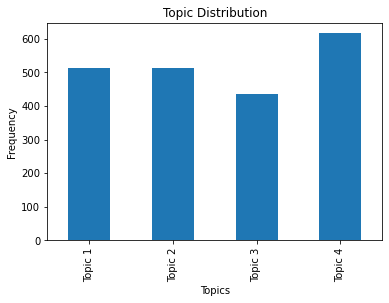

In [52]:
topic_distribution = pd.DataFrame(topic_weights)

topic_distribution.columns = [topic_labels[i] for i in range(topic_distribution.shape[1])]
topic_distribution.sum().plot(kind='bar')
plt.xlabel('Topics')
plt.ylabel('Frequency')
plt.title('Topic Distribution')
plt.show()

In [53]:

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
import pyLDAvis.sklearn

# # Create and fit the LDA model
lda_model = LatentDirichletAllocation(n_components=4 , max_iter= 20 ,  random_state=123)
lda_model.fit(tf_idf_arr)

# Prepare and display the visualization
prepared_data = pyLDAvis.sklearn.prepare(lda_model, tf_idf_arr, tf_idf_vectorizer)
pyLDAvis.display(prepared_data)


The above four circle majorly suggests us that the customers are highly disappointed:
A - Customer Support/ Customer Service / Ground Staff Service of the company.
B - Seat Comfort ; complains about old and uncomfortable seats.
C - Aren't satisfied with the services of Economy class / budgets

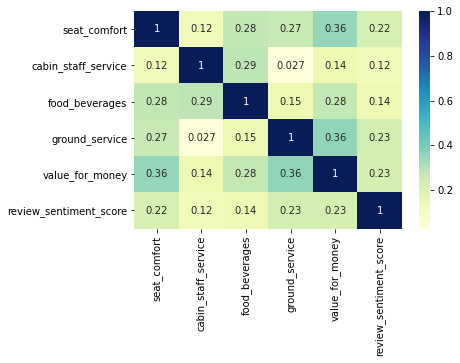

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt  
dataplot = sns.heatmap(no_data.corr(), cmap="YlGnBu", annot=True)
plt.show()

Looks like there is a correlation between value_for_money and seat_comfort , ground_service tells us that the
customer isn't happy with
the customer service of the company as well as with the airplane comfort services of the company. 

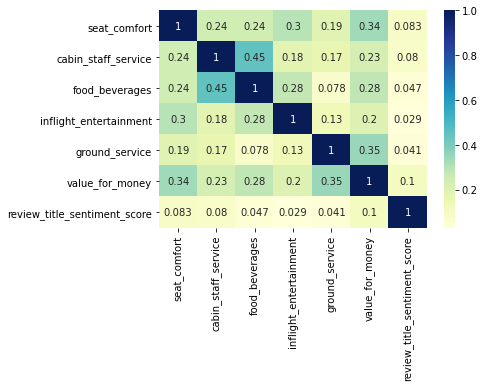

In [55]:
dataplot = sns.heatmap(no_title_data.corr(), cmap="YlGnBu", annot=True)
  
plt.show()

Again the tiltle of the review confirms our claims that the company should focus on the
customer service of the company as well as with the airplane comfort services of the company. 